In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Wed Nov 13 09:34:22 PST 2019


# Scatter of Accuracy vs Privacy

For TopDown, SampleDown, and theoretical limit

In [2]:
import dp_2020_census.data, dp_2020_census.model

In [3]:
import json
dname = '/ihme/homes/abie/projects/2019/dp_2020_census/'
with open(dname + 'results_sd_error.json') as f:
    results_sd_error = pd.Series(json.load(f))

In [4]:
with open(dname + 'results_sd_epl.json') as f:
    results_sd_epl = pd.Series(json.load(f))

In [5]:
with open(dname + 'results_dp_error.json') as f:
    results_dp_error = pd.Series(json.load(f))

In [6]:
with open(dname + 'results_dp_epl.json') as f:
    results_dp_epl = pd.Series(json.load(f))

# Calculate the error and empirical privacy loss for the geometric mechanism

In [7]:
df_orig = dp_2020_census.data.load_orig_counts()

In [8]:
eps_list_str = \
    '0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75 0.80 0.85 0.90 0.95'

In [9]:
def geometric_error(df_orig, epsilon, stratification_cols):
    z = epsilon
    N = 1_000_000
    error = np.random.geometric(z, size=N) - np.random.geometric(z, size=N)
    return pd.Series(error)

In [10]:
def find_geometric_epl(stratification_cols=['state', 'county', 'enum_dist'],
                       result_name='tc_privacy_loss_enum_dist'):
    results = {}

    for epsilon in eps_list_str.split():
        eps_str = f'{epsilon}min'
        key = f'{result_name}_{eps_str}'
        print(key, end=' - ')
    
        error = geometric_error(df_orig, float(epsilon), stratification_cols)
        
        df_epl = dp_2020_census.model.empirical_privacy_loss(error)
        max_abs = max(np.absolute(df_epl.smooth_epl))  # TODO: consider using 99-th percentile instead of max

        results[f'{key}_max_abs'] = f'{max_abs:.3f}'
        
        print(results[f'{key}_max_abs'])

    return results

# find_geometric_epl(['state',], 'tc_privacy_loss_state')

In [11]:
def find_geometric_error(stratification_cols=['state', 'county', 'enum_dist'], result_name='tc_enum_dist'):
    results = {}

    for epsilon in eps_list_str.split():
        eps_str = f'{epsilon}min'
        key = f'{result_name}_{eps_str}'
        print(key, end=' - ')
    
        error = geometric_error(df_orig, float(epsilon), stratification_cols)

        mae = np.median(np.absolute(error))
        pct95 = np.quantile(np.absolute(error), 0.95)
        max_ae = max(np.absolute(error))
        rmse = np.sqrt(np.mean(np.array(error)**2))
        
        results[f'{key}_mae'] = f'{mae:.0f}'
        results[f'{key}_pct95'] = f'{pct95:.0f}'
        results[f'{key}_max_ae'] = f'{max_ae:.0f}'
        results[f'{key}_rmse'] = f'{rmse:.2f}'
        
        print(np.round(np.mean(error),2), np.round(mae,2),
              np.round(rmse, 2), np.round(pct95,1),
              max_ae)

    return results
# find_geometric_error(['state', 'county'], 'tc_county')

In [12]:
%%time

epsilon = '0.05'
stratification_cols = ['state', 'county', 'enum_dist', 'age', 'race', 'eth']

error = geometric_error(df_orig, float(epsilon), stratification_cols)
df_epl = dp_2020_census.model.empirical_privacy_loss(error)

/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:83: RuntimeWarning: divide by zero encountered in log
  df['epl_cusum'] = np.log(ccusum[1:] / ccusum[:-1])


CPU times: user 9.8 s, sys: 228 ms, total: 10 s
Wall time: 9.88 s


# Produce scatter of MAE vs EPL

In [13]:
%%time

results_min_error = find_geometric_error(['state', 'county'], 'tc_county')
results_min_error = pd.Series(results_min_error)

tc_county_0.05min - 0.01 14.0 27.6 58.0 293
tc_county_0.10min - 0.01 7.0 13.43 28.0 151
tc_county_0.15min - 0.0 4.0 8.7 18.0 93
tc_county_0.20min - -0.0 3.0 6.32 13.0 65
tc_county_0.25min - 0.0 2.0 4.9 10.0 64
tc_county_0.30min - -0.01 2.0 3.95 8.0 40
tc_county_0.35min - -0.0 2.0 3.26 7.0 32
tc_county_0.40min - 0.0 1.0 2.74 6.0 43
tc_county_0.45min - -0.0 1.0 2.33 5.0 26
tc_county_0.50min - -0.0 1.0 2.0 4.0 22
tc_county_0.55min - -0.0 1.0 1.73 4.0 16
tc_county_0.60min - 0.0 1.0 1.49 3.0 15
tc_county_0.65min - 0.0 1.0 1.29 3.0 16
tc_county_0.70min - -0.0 0.0 1.11 2.0 12
tc_county_0.75min - 0.0 0.0 0.94 2.0 10
tc_county_0.80min - 0.0 0.0 0.79 2.0 9
tc_county_0.85min - -0.0 0.0 0.64 1.0 8
tc_county_0.90min - -0.0 0.0 0.5 1.0 6
tc_county_0.95min - -0.0 0.0 0.33 1.0 4
CPU times: user 7.15 s, sys: 320 ms, total: 7.47 s
Wall time: 7.42 s


In [14]:
results_sd_error.keys()

Index(['tc_state_5pct_mae', 'tc_state_5pct_pct95', 'tc_state_5pct_max_ae',
       'tc_state_5pct_rmse', 'tc_state_10pct_mae', 'tc_state_10pct_pct95',
       'tc_state_10pct_max_ae', 'tc_state_10pct_rmse', 'tc_state_15pct_mae',
       'tc_state_15pct_pct95',
       ...
       'sc_enum_dist_85pct_max_ae', 'sc_enum_dist_85pct_rmse',
       'sc_enum_dist_90pct_mae', 'sc_enum_dist_90pct_pct95',
       'sc_enum_dist_90pct_max_ae', 'sc_enum_dist_90pct_rmse',
       'sc_enum_dist_95pct_mae', 'sc_enum_dist_95pct_pct95',
       'sc_enum_dist_95pct_max_ae', 'sc_enum_dist_95pct_rmse'],
      dtype='object', length=456)

In [15]:
def my_plot_dp(cnt, unit, color, ymax):
    if cnt == 'tc' and unit == 'state': return  # invariant, so EPL is not defined
    xx = []
    yy = []
    for epsilon in '0.25 0.50 0.75 1.0 2.0 4.0 6.0 8.0'.split():
        eps_underscore = epsilon.replace('.', '_')
        xx.append(float(results_dp_epl[f'{cnt}_privacy_loss_{unit}_{eps_underscore}_max_abs']))
        yy.append(float(results_dp_error[f'{cnt}_{unit}_{eps_underscore}_mae']))
        if yy[-1] < ymax:
            if len(yy) == 1:
                plt.text(xx[-1], yy[-1], '  $\epsilon =$'+epsilon, ha='left', va='bottom', color=color)
            else:
                plt.text(xx[-1], yy[-1], '  '+epsilon, ha='left', va='bottom', color=color)
    plt.plot(xx, yy, 'o-', label=f'TopDown', color=color)

def my_plot_srs(cnt, unit, color, ymax, srs_str):
    xx = []
    yy = []
    for frac in srs_str.split():
        pct_str = f'{float(frac)*100:.0f}pct'
        xx.append(float(results_sd_epl[f'{cnt}_privacy_loss_{unit}_{pct_str}_max_abs']))
        yy.append(float(results_sd_error[f'{cnt}_{unit}_{pct_str}_mae']))
        if yy[-1] < ymax:
            plt.text(xx[-1], yy[-1], pct_str.replace('pct', '%')+'  ', ha='right', va='top', color=color)
    plt.plot(xx, yy, 's--', label=f'Simple Random Sample', color=color)


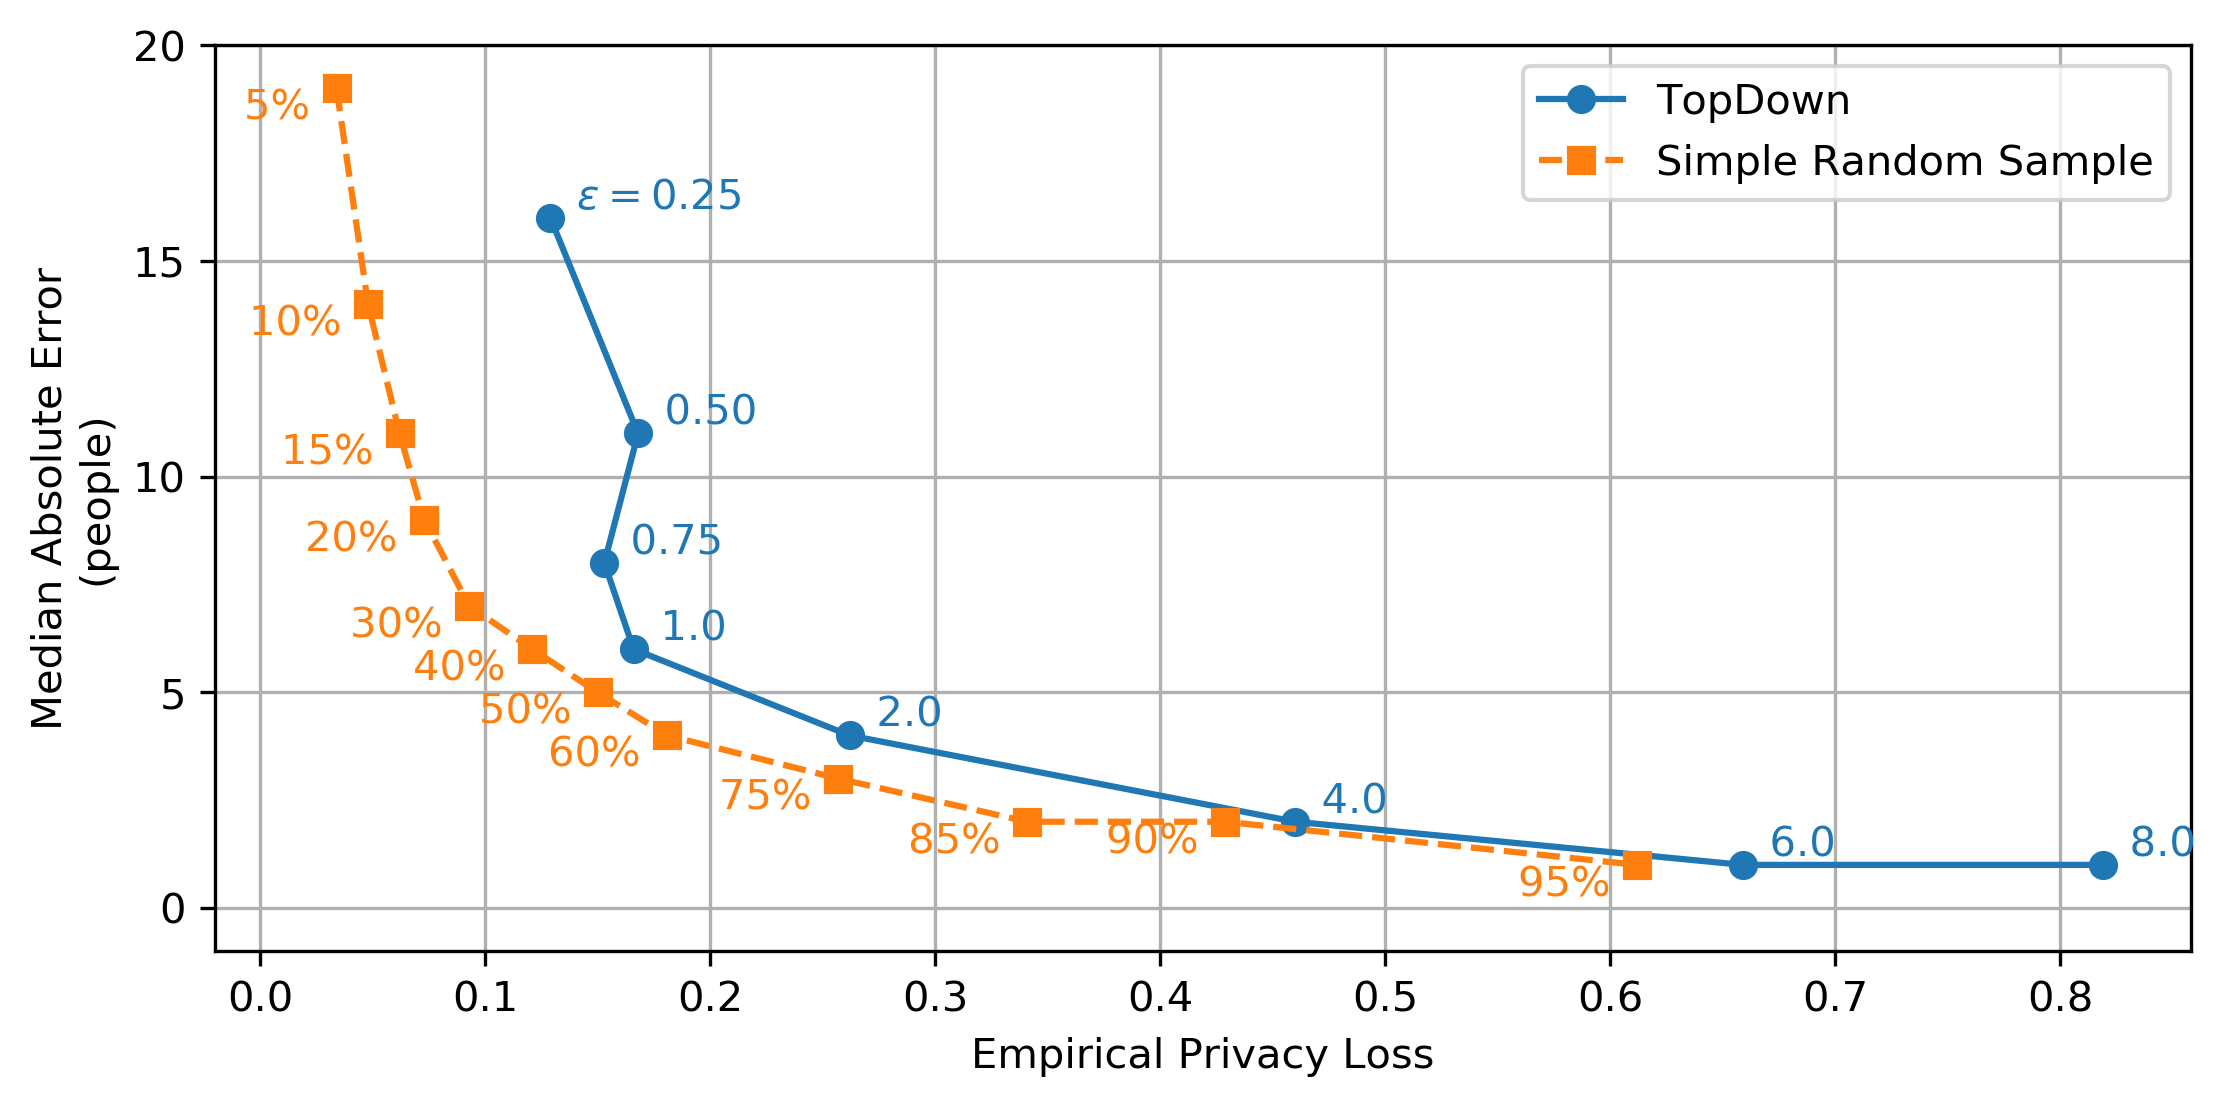

In [16]:
def compare_plot(cnt, unit, srs_str, ymax):
    plt.figure(figsize=(8.5, 4), dpi=300)
    
    color = 'C0'
    my_plot_dp(cnt, unit, 'C0', ymax)
    my_plot_srs(cnt, unit, 'C1', ymax, srs_str)

    plt.xlabel('Empirical Privacy Loss')
    plt.ylabel('Median Absolute Error\n(people)')
    plt.legend(loc='upper right')
    plt.axis(ymin=-1, ymax=ymax, xmin=-0.02)
    plt.grid()
    
compare_plot('sc', 'county', '0.05 0.10 0.15 0.20 0.30 0.40 0.50 0.60 0.75 0.85 0.90 0.95', 20)
plt.yticks(np.arange(0,21,5))
plt.savefig('/ihme/homes/abie/projects/2019/dp_2020_census/fig_2_td_vs_srs.png')

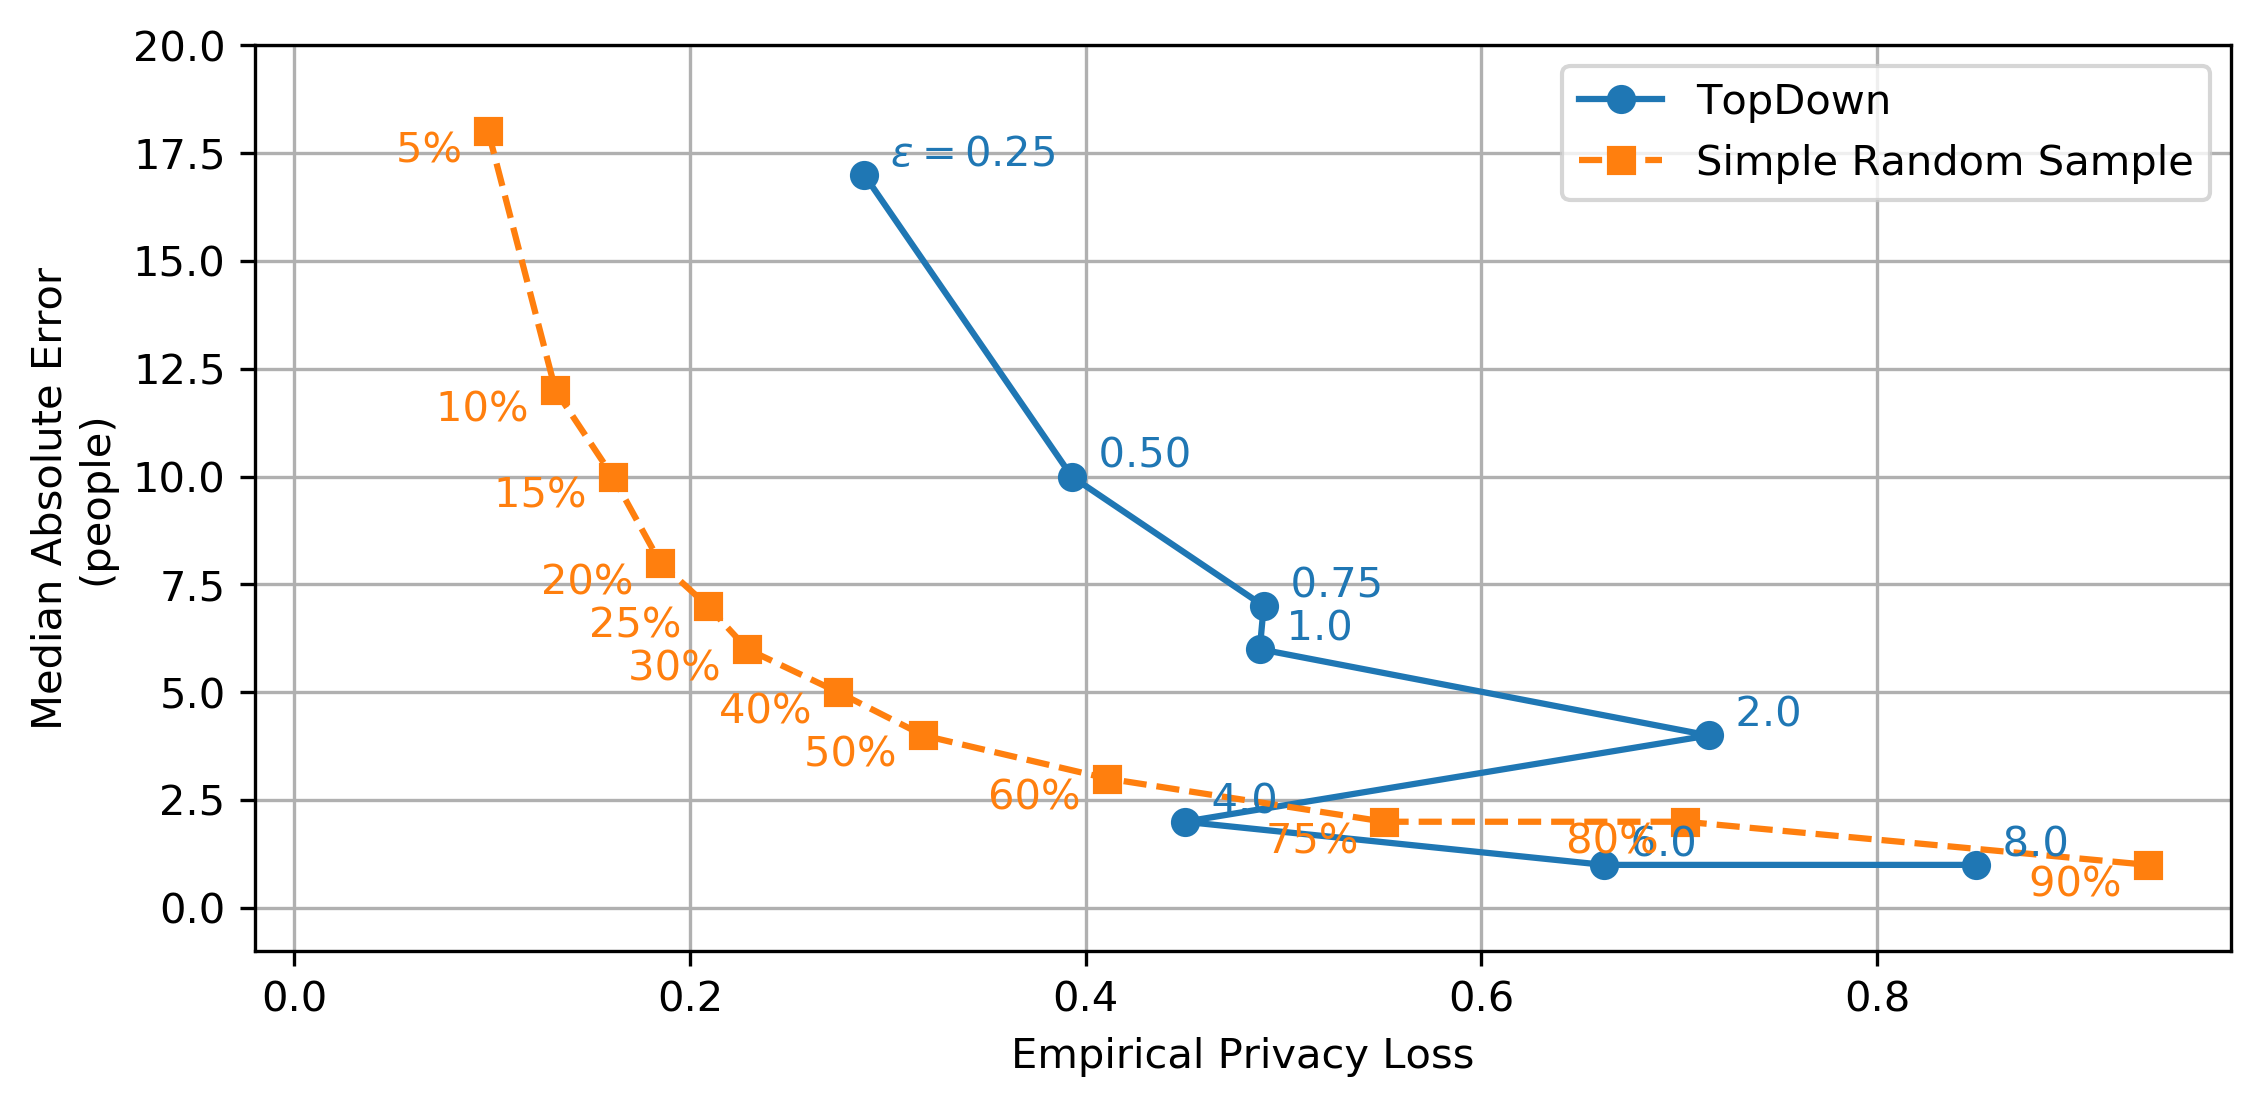

In [17]:
compare_plot('sc', 'enum_dist', '0.05 0.10 0.15 0.20 0.25 0.30 0.40 0.50 0.60 0.75 0.80 0.90', 20)

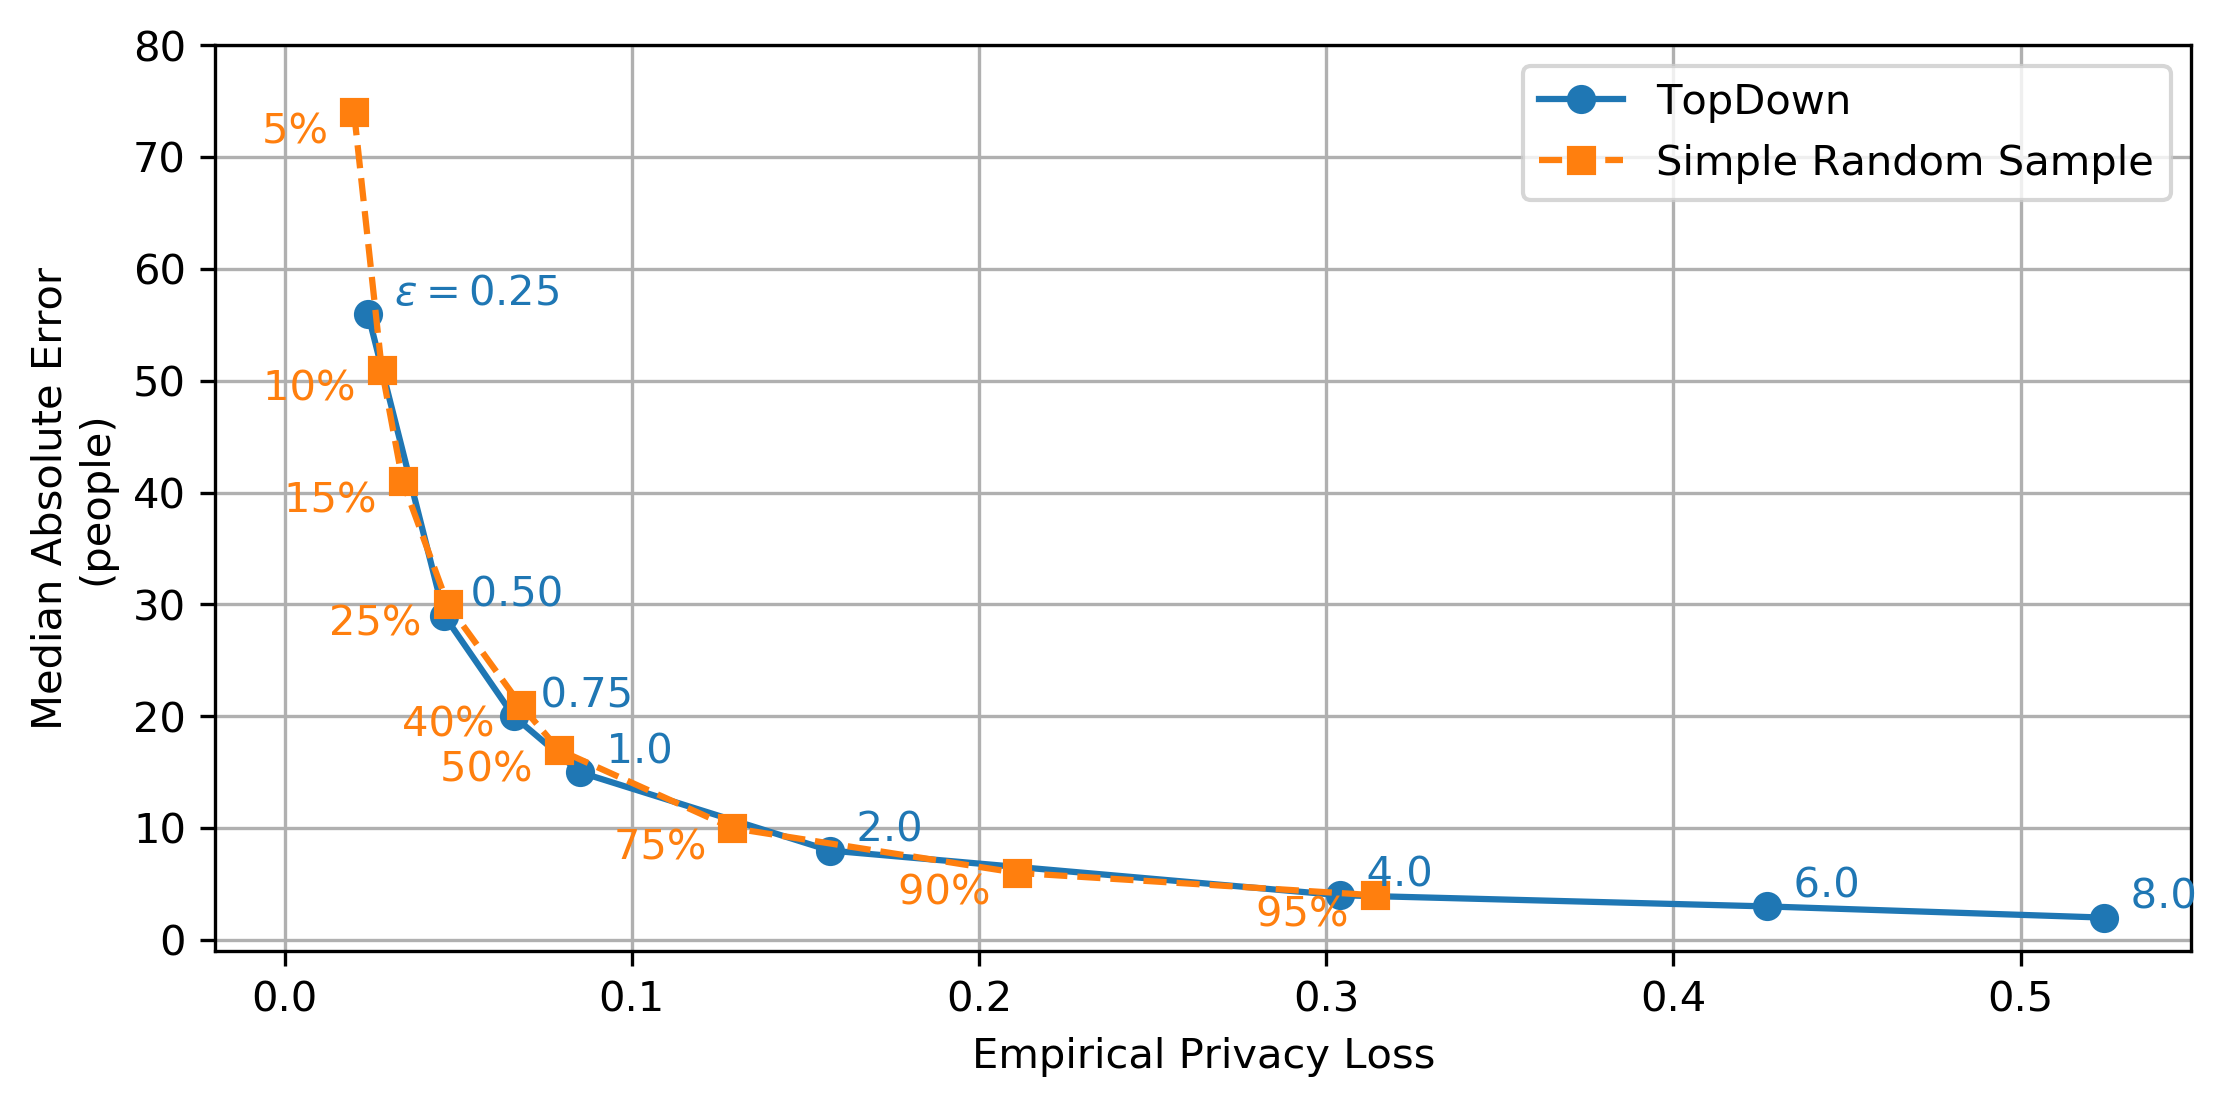

In [18]:
compare_plot('tc', 'enum_dist', '0.05 0.10 0.15 0.25 0.40 0.50 0.75 0.90 0.95', ymax=80)

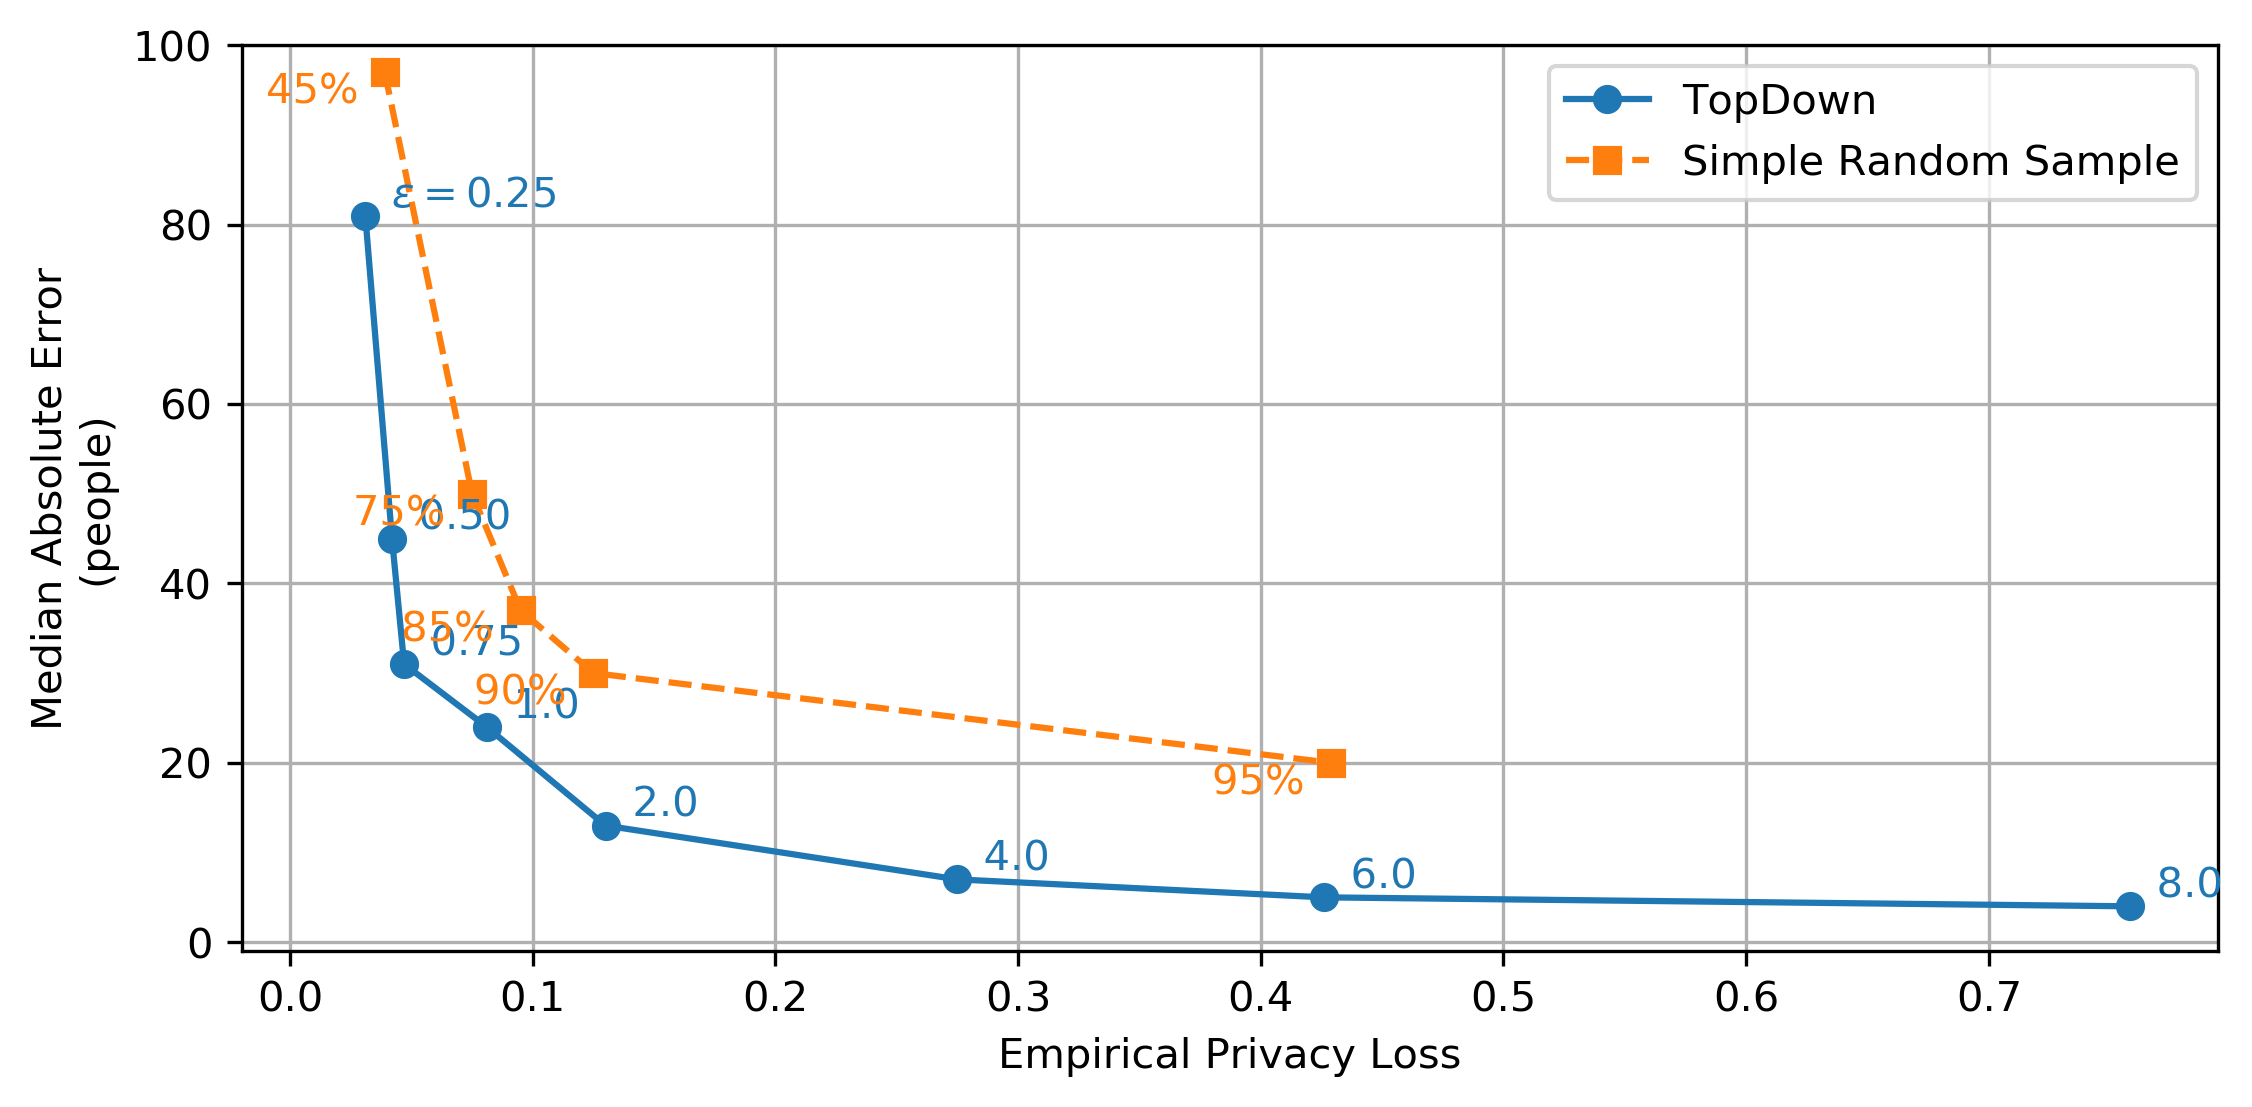

In [19]:
compare_plot('tc', 'county', '0.45 0.75 0.85 0.90 0.95', ymax=100)